Projet de Machine Learning

Problème de classification multi-variée en apprentissage supervisé.

---

Données : http://www.football-data.co.uk/germanym.php

Ou déjà téléchargé dans mes dossiers : Data\Projets de Machine Learning\Odds football\Datasets

---

L'objectif de ce projet est de **prédire l'issue d'un match de foot**, c'est-à-dire prédire quelle équipe va gagner ou s'il y aura un match nul.

Je n'ai pas eu besoin de beaucoup nettoyer le jeu de données car il n'y avait pas beaucoup de donnée manquante. Par contre, j'ai fait beaucoup de feature engineering. J'ai par exemple créé les variables 'Saison' et 'Numéro de la journée'. Cela m'a permis ensuite de créer des variables relatives à l'état de forme de chaque équipe comme le nombre de buts marqués et pris ou nombre de points obtenus et cela pour les 10 derniers matchs.


J'ai commencer par entrainer mes modèles sur les données de 2 saisons consécutives et à les tester sur la saison suivante. La performance des modèles tournaient autour des 50% de bonnes prédictions. Vu qu'il y avait dans les datasets les côtes avant-match pour les victoires et match nul, j'ai pu calculer si mes modèles étaient rentables. Très peu l'étaient. En plus de ça, ils n'étaient pas robustes. C'est-à-dire que lors qu'on décaler tout d'une saison (les 2 saisons pour l'apprentissage et la saison pour le test), la rentabilité n'était pas la même. 

Problème : beaucoup d'over-fitting car le résultat d'un match de foot reste imprévisible

J'ai donc essayer d'entrainer mes modèles non pas sur les deux saisons précédents la saison à prédire mais sur les 10 saisons précédentes. Cela afin de réduite l'over-fitting. Les performances tournaient alors entre 40 à 60% selon les modèles et la saison à prédire. Certains modèles étaient rentables pour une saison mais pas pour la saison d'après. En résumé, je n'ai pas trouvé de modèle vraiment robuste.

Les deux modèles qui n'étaient certes pas totalement robustes mais qui étaient souvent rentables étaient le **DecisionTreeClassifier** et le **KNeighborsClassifier**.

Je les ai testé sur les saisons de Bundesliga, Premier League ainsi que de Ligue 1. En augmentant, l'hyper-paramètre 'nombre de voisons' de KNeighborsClassifier, j'arriverai souvent à un ensemble de k pour lesquels le modèle était rentable. Cependant, cet ensemble de k varié selon la saison à prédire et la ligue étudiée. 

Bilan du projet : **DecisionTreeClassifier** et **KNeighborsClassifier** étaient parfois rentables mais jamais robustes. C'est-à-dire que leurs hyper-paramètres avec lesquels ils étaient rentables pour une saison variés selon la saison et la ligue.

Imports de **bibliothèques**


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Connexion avec le Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Gestion de l'affichage

In [ ]:
pd.set_option('display.max_row', 100)
pd.set_option('display.max_column', 100)

**Importation des datasets**




In [ ]:
liste_annees = ['2008_2009','2009_2010','2010_2011','2011_2012',
                '2012_2013','2013_2014','2014_2015','2015_2016','2016_2017','2017_2018','2018_2019','2019_2020']
annee_debut = 2009 # 2008-2009
annee_fin = 2020 # 2019-2020

In [ ]:
def importation_donnees(liste_annees):
  liste_data = []
  for annee in liste_annees:
    data = 'data' + annee
    # data = pd.read_csv(f'/content/Bundesliga{annee}.csv')
    data = pd.read_csv(f'/content/PL{annee}.csv')
    liste_data.append(data)
  return liste_data

liste_data = importation_donnees(liste_annees)

nombre_equipe = 20
nombre_journee = liste_data[0].shape[0] / (nombre_equipe/2)
liste_data[-1].tail()

In [ ]:
def rapport_data(liste_data, liste_annees):
  for data, annee in zip(liste_data, liste_annees):
    print(f'Années {annee} :')
    print(f'Dimension : {data.shape[0]} lignes et {data.shape[1]} colonnes')
    print('Répartition target (en %) :')
    print(round(data['FTR'].value_counts(normalize=True)*100,2))
    print('\n_______________________\n')

rapport_data(liste_data, liste_annees)

Années 2008_2009 :
Dimension : 380 lignes et 71 colonnes
Répartition target (en %) :
H    45.53
A    28.95
D    25.53
Name: FTR, dtype: float64

_______________________

Années 2009_2010 :
Dimension : 380 lignes et 71 colonnes
Répartition target (en %) :
H    50.79
D    25.26
A    23.95
Name: FTR, dtype: float64

_______________________

Années 2010_2011 :
Dimension : 380 lignes et 71 colonnes
Répartition target (en %) :
H    47.11
D    29.21
A    23.68
Name: FTR, dtype: float64

_______________________

Années 2011_2012 :
Dimension : 380 lignes et 71 colonnes
Répartition target (en %) :
H    45.00
A    30.53
D    24.47
Name: FTR, dtype: float64

_______________________

Années 2012_2013 :
Dimension : 380 lignes et 74 colonnes
Répartition target (en %) :
H    43.68
D    28.42
A    27.89
Name: FTR, dtype: float64

_______________________

Années 2013_2014 :
Dimension : 380 lignes et 68 colonnes
Répartition target (en %) :
H    47.11
A    32.37
D    20.53
Name: FTR, dtype: float64

_____

In [ ]:
def nettoyage(liste_data):
  new_liste = []
  for data in liste_data:
    data = data[['Date','HomeTeam','AwayTeam','FTHG','FTAG','FTR','B365H','B365D','B365A']]
    new_liste.append(data)
  return new_liste

liste_data = nettoyage(liste_data)

print(liste_data[0].dtypes)
liste_data[0].head()

Date         object
HomeTeam     object
AwayTeam     object
FTHG          int64
FTAG          int64
FTR          object
B365H       float64
B365D       float64
B365A       float64
dtype: object


,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,B365H,B365D,B365A
0,16/08/08,Arsenal,West Brom,1,0,H,1.20,6.5,15.00
1,16/08/08,Bolton,Stoke,3,1,H,1.83,3.5,4.50
2,16/08/08,Everton,Blackburn,2,3,A,2.00,3.3,4.00
3,16/08/08,Hull,Fulham,2,1,H,2.60,3.2,2.80
4,16/08/08,Middlesbrough,Tottenham,2,1,H,3.20,3.4,2.25


In [ ]:
def recodage_date(liste_data, liste_annees):
  new_liste = []
  for data, annee in zip(liste_data, liste_annees):
    if annee in ['2017_2018','2018_2019','2019_2020']:
      data['Date'] = pd.to_datetime(data['Date'], format="%d/%m/%Y")
      new_liste.append(data)
    else:
      data['Date'] = pd.to_datetime(data['Date'], format="%d/%m/%y")
      new_liste.append(data)
  return new_liste

liste_data = recodage_date(liste_data, liste_annees)

print(liste_data[0].dtypes)
liste_data[0].head()

Date        datetime64[ns]
HomeTeam            object
AwayTeam            object
FTHG                 int64
FTAG                 int64
FTR                 object
B365H              float64
B365D              float64
B365A              float64
dtype: object


,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,B365H,B365D,B365A
0,2008-08-16,Arsenal,West Brom,1,0,H,1.20,6.5,15.00
1,2008-08-16,Bolton,Stoke,3,1,H,1.83,3.5,4.50
2,2008-08-16,Everton,Blackburn,2,3,A,2.00,3.3,4.00
3,2008-08-16,Hull,Fulham,2,1,H,2.60,3.2,2.80
4,2008-08-16,Middlesbrough,Tottenham,2,1,H,3.20,3.4,2.25


In [ ]:
def fusion(liste_data):
  return pd.concat(liste_data)

data = fusion(liste_data)
rapport_data([data], [f'de {liste_annees[0]} à {liste_annees[-1]}'])
data.dtypes

Années de 2008_2009 à 2019_2020 :
Dimension : 4469 lignes et 9 colonnes
Répartition target (en %) :
H    46.11
A    29.07
D    24.82
Name: FTR, dtype: float64

_______________________



Date        datetime64[ns]
HomeTeam            object
AwayTeam            object
FTHG               float64
FTAG               float64
FTR                 object
B365H              float64
B365D              float64
B365A              float64
dtype: object

**Ajout d'une colonne** 'Saison'

In [ ]:
def transforme_saison(date):
  if pd.Timestamp(2003,8,1) < date < pd.Timestamp(2004,7,1):
    return 2004
  elif pd.Timestamp(2004,8,1) < date < pd.Timestamp(2005,7,1):
    return 2005
  elif pd.Timestamp(2005,8,1) < date < pd.Timestamp(2006,7,1):
    return 2006
  elif pd.Timestamp(2006,8,1) < date < pd.Timestamp(2007,7,1):
    return 2007
  elif pd.Timestamp(2007,8,1) < date < pd.Timestamp(2008,7,1):
    return 2008
  elif pd.Timestamp(2008,8,1) < date < pd.Timestamp(2009,7,1):
    return 2009
  elif pd.Timestamp(2009,8,1) < date < pd.Timestamp(2010,7,1):
    return 2010
  elif pd.Timestamp(2010,8,1) < date < pd.Timestamp(2011,7,1):
    return 2011
  elif pd.Timestamp(2011,8,1) < date < pd.Timestamp(2012,7,1):
    return 2012
  elif pd.Timestamp(2012,8,1) < date < pd.Timestamp(2013,7,1):
    return 2013
  elif pd.Timestamp(2013,8,1) < date < pd.Timestamp(2014,7,1):
    return 2014
  elif pd.Timestamp(2014,8,1) < date < pd.Timestamp(2015,7,1):
    return 2015
  elif pd.Timestamp(2015,8,1) < date < pd.Timestamp(2016,7,1):
    return 2016
  elif pd.Timestamp(2016,8,1) < date < pd.Timestamp(2017,7,1):
    return 2017
  elif pd.Timestamp(2017,8,1) < date < pd.Timestamp(2018,7,1):
    return 2018
  elif pd.Timestamp(2018,8,1) < date < pd.Timestamp(2019,7,1):
    return 2019
  elif pd.Timestamp(2019,8,1) < date < pd.Timestamp(2020,7,31):
    return 2020

**Ajout** des colonnes 'Historique_FTHG' et 'Historique_FTAG' contenant le score de la dernière confrontation

In [ ]:
def historique_FTHG(saison,ht,at):
  result = (data[(data['Saison'] == saison - 1) & 
                 (data['HomeTeam']==ht) & 
                 (data['AwayTeam']==at)]['FTHG']).to_string()[-1] 
  if (saison != annee_debut) and (result in ['0','1','2','3','4','5','6','7','8','9','10']):
    return int(result)
  else:
    return -1

def historique_FTAG(saison,ht,at):
  result = (data[(data['Saison'] == saison - 1) & (data['HomeTeam']==ht) & (data['AwayTeam']==at)]['FTAG']).to_string()[-1] 
  if (saison != annee_debut) and (result in ['0','1','2','3','4','5','6','7','8','9','10']):
    return int(result)
  else:
    return -1

def historique_FTHG_inverse(saison,ht,at):
  result = (data[(data['Saison'] == saison - 1) & 
                 (data['HomeTeam']==at) & 
                 (data['AwayTeam']==ht)]['FTAG']).to_string()[-1] 
  if (saison != annee_debut) and (result in ['0','1','2','3','4','5','6','7','8','9','10']):
    return int(result)
  else:
    return -1

def historique_FTAG_inverse(saison,ht,at):
  result = (data[(data['Saison'] == saison - 1) &
                 (data['HomeTeam']==at) &
                 (data['AwayTeam']==ht)]['FTHG']).to_string()[-1] 
  if (saison != annee_debut) and (result in ['0','1','2','3','4','5','6','7','8','9','10']):
    return int(result)
  else:
    return -1

**Ajout** d'une colonne 'Derniere_confrontation' contenant le résultat (H,D,A) de la dernière confrontation

In [ ]:
def historique_result(saison,ht,at):
  result = (data[(data['Saison'] == saison - 1) & (data['HomeTeam']==ht) & (data['AwayTeam']==at)]['FTR']).to_string()[-1] 
  if (saison != annee_debut) and (result in ['D','H','A']):
    return result
  else:
    return np.nan

**Ajout** des colonnes 'H_pst_an_dernier' et 'A_pst_an_dernier' contenant le résultat (H,D,A) de la dernière confrontation

In [ ]:
def ancien_2H(saison,ht,dc):
  if (saison != annee_debut) and (ht in data[data['Saison']==saison-1]['HomeTeam'].unique()):
    return 1
  else:
    return 0

def ancien_2A(saison,at,dc):
  if (saison != annee_debut) and (at in data[data['Saison']==saison-1]['AwayTeam'].unique()):
    return 1
  else:
    return 0

#print(data[data['Saison']==2019]['H_pst_an_dernier'].value_counts()) # 2 équipes x 17 matchs = 34 modalité 0
#data.tail(10)

**Ajout** d'une colonne 'Numero_journee'

In [ ]:
def num_journee(data):
  data['Numero_journee'] = 0
  for saison in [2016,2017,2018,2019]:
    for team in data[data['Saison']==saison]['HomeTeam'].unique():
      cpt = 1
      for indice, value in data[(data['Saison']==saison) & ((data['HomeTeam']==team) | (data['AwayTeam']==team))].iterrows():
        data.loc[indice,'Numero_journee'] = cpt
        cpt += 1

**Ajout** des colonnes 'H_Nb_buts_marques_10' et 'A_Nb_buts_marques_10' avec les nombre de buts marqués sur les 10 derniers matchs

In [ ]:
def nb_buts_marque_H10(saison,nj,ht):
  if nj > 10:
    somme1 = data[(data['Saison']==saison) & (data['HomeTeam']==ht) & (data['Numero_journee']<nj) & (data['Numero_journee']>=nj-10)]['FTHG'].sum()
    somme2 = data[(data['Saison']==saison) & (data['AwayTeam']==ht) & (data['Numero_journee']<nj) & (data['Numero_journee']>=nj-10)]['FTAG'].sum()
    return somme1 + somme2
  else:
    n = 10 - nj
    somme1 = data[(data['Saison']==saison) & (data['HomeTeam']==ht) & (data['Numero_journee']<nj)]['FTHG'].sum()
    somme2 = data[(data['Saison']==saison) & (data['AwayTeam']==ht) & (data['Numero_journee']<nj)]['FTAG'].sum()
    somme3 = data[(data['Saison']==saison-1) & (data['HomeTeam']==ht) & (data['Numero_journee']>=nombre_journee-n)]['FTHG'].sum() 
    somme4 = data[(data['Saison']==saison-1) & (data['AwayTeam']==ht) & (data['Numero_journee']>=nombre_journee-n)]['FTAG'].sum() 
    return somme1 + somme2 + somme3 + somme4 

def nb_buts_marque_A10(saison,nj,at):
  if nj > 10:
    somme1 = data[(data['Saison']==saison) & (data['HomeTeam']==at) & (data['Numero_journee']<nj) & (data['Numero_journee']>=nj-10)]['FTHG'].sum()
    somme2 = data[(data['Saison']==saison) & (data['AwayTeam']==at) & (data['Numero_journee']<nj) & (data['Numero_journee']>=nj-10)]['FTAG'].sum()
    return somme1 + somme2
  else:
    n = 10 - nj
    somme1 = data[(data['Saison']==saison) & (data['HomeTeam']==at) & (data['Numero_journee']<nj)]['FTHG'].sum()
    somme2 = data[(data['Saison']==saison) & (data['AwayTeam']==at) & (data['Numero_journee']<nj)]['FTAG'].sum()
    somme3 = data[(data['Saison']==saison-1) & (data['HomeTeam']==at) & (data['Numero_journee']>=nombre_journee-n)]['FTHG'].sum() 
    somme4 = data[(data['Saison']==saison-1) & (data['AwayTeam']==at) & (data['Numero_journee']>=nombre_journee-n)]['FTAG'].sum() 
    return somme1 + somme2 + somme3 + somme4

#data[((data['Saison']==2018) | (data['Saison']==2019)) & ((data['HomeTeam']=='Bayern Munich') | (data['AwayTeam']=='Bayern Munich'))][['Numero_journee','HomeTeam','AwayTeam','FTHG','FTAG','Saison','H_Nb_buts_marques_10','A_Nb_buts_marques_10','H_Nb_buts_pris_10','A_Nb_buts_pris_10']]
#data.tail()

**Ajout** des colonnes 'H_Nb_buts_pris_10' et 'A_Nb_buts_pris_10' avec les nombre de buts encaissés sur les 10 derniers matchs

In [ ]:
def nb_buts_encaisse_H10(saison,nj,ht):
  if nj > 10:
    somme1 = data[(data['Saison']==saison) & (data['HomeTeam']==ht) & (data['Numero_journee']<nj) & (data['Numero_journee']>=nj-10)]['FTAG'].sum()
    somme2 = data[(data['Saison']==saison) & (data['AwayTeam']==ht) & (data['Numero_journee']<nj) & (data['Numero_journee']>=nj-10)]['FTHG'].sum()
    return somme1 + somme2
  else:
    n = 10 - nj
    somme1 = data[(data['Saison']==saison) & (data['HomeTeam']==ht) & (data['Numero_journee']<nj)]['FTAG'].sum()
    somme2 = data[(data['Saison']==saison) & (data['AwayTeam']==ht) & (data['Numero_journee']<nj)]['FTHG'].sum()
    somme3 = data[(data['Saison']==saison-1) & (data['HomeTeam']==ht) & (data['Numero_journee']>=nombre_journee-n)]['FTAG'].sum() 
    somme4 = data[(data['Saison']==saison-1) & (data['AwayTeam']==ht) & (data['Numero_journee']>=nombre_journee-n)]['FTHG'].sum() 
    return somme1 + somme2 + somme3 + somme4

def nb_buts_encaisse_A10(saison,nj,at):
  if nj > 10:
    somme1 = data[(data['Saison']==saison) & (data['HomeTeam']==at) & (data['Numero_journee']<nj) & (data['Numero_journee']>=nj-10)]['FTAG'].sum()
    somme2 = data[(data['Saison']==saison) & (data['AwayTeam']==at) & (data['Numero_journee']<nj) & (data['Numero_journee']>=nj-10)]['FTHG'].sum()
    return somme1 + somme2
  else:
    n = 10 - nj
    somme1 = data[(data['Saison']==saison) & (data['HomeTeam']==at) & (data['Numero_journee']<nj)]['FTAG'].sum()
    somme2 = data[(data['Saison']==saison) & (data['AwayTeam']==at) & (data['Numero_journee']<nj)]['FTHG'].sum()
    somme3 = data[(data['Saison']==saison-1) & (data['HomeTeam']==at) & (data['Numero_journee']>=nombre_journee-n)]['FTAG'].sum() 
    somme4 = data[(data['Saison']==saison-1) & (data['AwayTeam']==at) & (data['Numero_journee']>=nombre_journee-n)]['FTHG'].sum() 
    return somme1 + somme2 + somme3 + somme4

#data[(data['Saison']==2019) & ((data['HomeTeam']=='Bayern Munich') | (data['AwayTeam']=='Bayern Munich'))]
#data.tail(10)

**Ajout** des colonnes 'Point_H' et 'Point_A' pour pouvoir ensuite calculer les nb de points et de victoire, défaite, nul sur les 10 derniers matchs

In [ ]:
def point_H(ftr):
  if ftr == 'D':
    return 1
  elif ftr == 'H':
    return 3
  else:
    return 0

def point_A(ftr):
  if ftr == 'D':
    return 1
  elif ftr == 'A':
    return 3
  else:
    return 0

#data.tail()

**Ajout** des colonnes 'H_Nb_points_10' et 'A_Nb_points_10' contenant le nombre de points obtenus lors des 10 derniers matchs

In [ ]:
def H_Nb_points_10(saison,nj,ht):
  if nj > 10:
    somme1 = data[(data['Saison']==saison) & (data['HomeTeam']==ht) & (data['Numero_journee']<nj) & (data['Numero_journee']>=nj-10)]['Point_H'].sum()
    somme2 = data[(data['Saison']==saison) & (data['AwayTeam']==ht) & (data['Numero_journee']<nj) & (data['Numero_journee']>=nj-10)]['Point_A'].sum()
    return somme1 + somme2
  else:
    n = 10 - nj
    somme1 = data[(data['Saison']==saison) & (data['HomeTeam']==ht) & (data['Numero_journee']<nj)]['Point_H'].sum()
    somme2 = data[(data['Saison']==saison) & (data['AwayTeam']==ht) & (data['Numero_journee']<nj)]['Point_A'].sum()
    somme3 = data[(data['Saison']==saison-1) & (data['HomeTeam']==ht) & (data['Numero_journee']>=nombre_journee-n)]['Point_H'].sum() 
    somme4 = data[(data['Saison']==saison-1) & (data['AwayTeam']==ht) & (data['Numero_journee']>=nombre_journee-n)]['Point_A'].sum() 
    return somme1 + somme2 + somme3 + somme4

def A_Nb_points_10(saison,nj,at):
  if nj > 10:
    somme1 = data[(data['Saison']==saison) & (data['HomeTeam']==at) & (data['Numero_journee']<nj) & (data['Numero_journee']>=nj-10)]['Point_H'].sum()
    somme2 = data[(data['Saison']==saison) & (data['AwayTeam']==at) & (data['Numero_journee']<nj) & (data['Numero_journee']>=nj-10)]['Point_A'].sum()
    return somme1 + somme2
  else:
    n = 10 - nj
    somme1 = data[(data['Saison']==saison) & (data['HomeTeam']==at) & (data['Numero_journee']<nj)]['Point_H'].sum()
    somme2 = data[(data['Saison']==saison) & (data['AwayTeam']==at) & (data['Numero_journee']<nj)]['Point_A'].sum()
    somme3 = data[(data['Saison']==saison-1) & (data['HomeTeam']==at) & (data['Numero_journee']>=nombre_journee-n)]['Point_H'].sum() 
    somme4 = data[(data['Saison']==saison-1) & (data['AwayTeam']==at) & (data['Numero_journee']>=nombre_journee-n)]['Point_A'].sum() 
    return somme1 + somme2 + somme3 + somme4

#data[((data['Saison']==2018) | (data['Saison']==2019)) & ((data['HomeTeam']=='Bayern Munich') | (data['AwayTeam']=='Bayern Munich'))][['HomeTeam','AwayTeam','FTR','Numero_journee','Point_H','Point_A','H_Nb_points_10','A_Nb_points_10']]
#data.tail(10)

**Ajout** des colonnes 'H_Nb_victoire_10' et 'A_Nb_victoire_10' contenant le nombre de victoires obtenues lors des 10 derniers matchs

In [ ]:
def H_Nb_victoire_10(saison,nj,ht):
  if nj > 10:
    somme1 = data[(data['Saison']==saison) & (data['HomeTeam']==ht) & (data['Numero_journee']<nj) & (data['Numero_journee']>=nj-10) & (data['FTR']=='H')].shape[0]
    somme2 = data[(data['Saison']==saison) & (data['AwayTeam']==ht) & (data['Numero_journee']<nj) & (data['Numero_journee']>=nj-10) & (data['FTR']=='A')].shape[0]
    return somme1 + somme2
  else:
    n = 10 - nj
    somme1 = data[(data['Saison']==saison) & (data['HomeTeam']==ht) & (data['Numero_journee']<nj) & (data['FTR']=='H')].shape[0]
    somme2 = data[(data['Saison']==saison) & (data['AwayTeam']==ht) & (data['Numero_journee']<nj) & (data['FTR']=='A')].shape[0]
    somme3 = data[(data['Saison']==saison-1) & (data['HomeTeam']==ht) & (data['Numero_journee']>=nombre_journee-n) & (data['FTR']=='H')].shape[0]
    somme4 = data[(data['Saison']==saison-1) & (data['AwayTeam']==ht) & (data['Numero_journee']>=nombre_journee-n) & (data['FTR']=='A')].shape[0] 
    return somme1 + somme2 + somme3 + somme4

def A_Nb_victoire_10(saison,nj,at):
  if nj > 10:
    somme1 = data[(data['Saison']==saison) & (data['HomeTeam']==at) & (data['Numero_journee']<nj) & (data['Numero_journee']>=nj-10) & (data['FTR']=='H')].shape[0]
    somme2 = data[(data['Saison']==saison) & (data['AwayTeam']==at) & (data['Numero_journee']<nj) & (data['Numero_journee']>=nj-10) & (data['FTR']=='A')].shape[0]
    return somme1 + somme2
  else:
    n = 10 - nj
    somme1 = data[(data['Saison']==saison) & (data['HomeTeam']==at) & (data['Numero_journee']<nj) & (data['FTR']=='H')].shape[0]
    somme2 = data[(data['Saison']==saison) & (data['AwayTeam']==at) & (data['Numero_journee']<nj) & (data['FTR']=='A')].shape[0]
    somme3 = data[(data['Saison']==saison-1) & (data['HomeTeam']==at) & (data['Numero_journee']>=nombre_journee-n) & (data['FTR']=='H')].shape[0] 
    somme4 = data[(data['Saison']==saison-1) & (data['AwayTeam']==at) & (data['Numero_journee']>=nombre_journee-n) & (data['FTR']=='A')].shape[0] 
    return somme1 + somme2 + somme3 + somme4

#data[((data['Saison']==2018) | (data['Saison']==2019)) & ((data['HomeTeam']=='Bayern Munich') | (data['AwayTeam']=='Bayern Munich'))][['HomeTeam','AwayTeam','FTR','Numero_journee','H_Nb_victoire_10','A_Nb_victoire_10']]
#data.tail(10)

**Ajout** des colonnes 'H_Nb_defaite_10' et 'A_Nb_defaite_10' contenant le nombre de défaites obtenues lors des 10 derniers matchs

In [ ]:
def H_Nb_defaite_10(saison,nj,ht):
  if nj > 10:
    somme1 = data[(data['Saison']==saison) & (data['HomeTeam']==ht) & (data['Numero_journee']<nj) & (data['Numero_journee']>=nj-10) & (data['FTR']=='A')].shape[0]
    somme2 = data[(data['Saison']==saison) & (data['AwayTeam']==ht) & (data['Numero_journee']<nj) & (data['Numero_journee']>=nj-10) & (data['FTR']=='H')].shape[0]
    return somme1 + somme2
  else:
    n = 10 - nj
    somme1 = data[(data['Saison']==saison) & (data['HomeTeam']==ht) & (data['Numero_journee']<nj) & (data['FTR']=='A')].shape[0]
    somme2 = data[(data['Saison']==saison) & (data['AwayTeam']==ht) & (data['Numero_journee']<nj) & (data['FTR']=='H')].shape[0]
    somme3 = data[(data['Saison']==saison-1) & (data['HomeTeam']==ht) & (data['Numero_journee']>=nombre_journee-n) & (data['FTR']=='A')].shape[0] 
    somme4 = data[(data['Saison']==saison-1) & (data['AwayTeam']==ht) & (data['Numero_journee']>=nombre_journee-n) & (data['FTR']=='H')].shape[0] 
    return somme1 + somme2 + somme3 + somme4

def A_Nb_defaite_10(saison,nj,at):
  if nj > 10:
    somme1 = data[(data['Saison']==saison) & (data['HomeTeam']==at) & (data['Numero_journee']<nj) & (data['Numero_journee']>=nj-10) & (data['FTR']=='A')].shape[0]
    somme2 = data[(data['Saison']==saison) & (data['AwayTeam']==at) & (data['Numero_journee']<nj) & (data['Numero_journee']>=nj-10) & (data['FTR']=='H')].shape[0]
    return somme1 + somme2
  else:
    n = 10 - nj
    somme1 = data[(data['Saison']==saison) & (data['HomeTeam']==at) & (data['Numero_journee']<nj) & (data['FTR']=='A')].shape[0]
    somme2 = data[(data['Saison']==saison) & (data['AwayTeam']==at) & (data['Numero_journee']<nj) & (data['FTR']=='H')].shape[0]
    somme3 = data[(data['Saison']==saison-1) & (data['HomeTeam']==at) & (data['Numero_journee']>=nombre_journee-n) & (data['FTR']=='A')].shape[0] 
    somme4 = data[(data['Saison']==saison-1) & (data['AwayTeam']==at) & (data['Numero_journee']>=nombre_journee-n) & (data['FTR']=='H')].shape[0] 
    return somme1 + somme2 + somme3 + somme4

#data[((data['Saison']==2018) | (data['Saison']==2019)) & ((data['HomeTeam']=='Bayern Munich') | (data['AwayTeam']=='Bayern Munich'))][['HomeTeam','AwayTeam','FTR','Numero_journee','H_Nb_defaite_10','A_Nb_defaite_10']]
#data.tail(10)

**Ajout** des colonnes 'H_Nb_nul_10' et 'A_Nb_nul_10' contenant le nombre de matchs nuls obtenus lors des 10 derniers matchs

In [ ]:
def Nb_nul_10(saison,nj,t):
  if nj > 10:
    return data[(data['Saison']==saison) & ((data['HomeTeam']==t) | (data['AwayTeam']==t)) & (data['Numero_journee']<nj) & (data['Numero_journee']>=nj-10) & (data['FTR']=='D')].shape[0]
  else:
    n = 10 - nj
    somme1 = data[(data['Saison']==saison) & ((data['HomeTeam']==t) | (data['AwayTeam']==t)) & (data['Numero_journee']<nj) & (data['FTR']=='D')].shape[0]
    somme2 = data[(data['Saison']==saison-1) & ((data['HomeTeam']==t) | (data['AwayTeam']==t)) & (data['Numero_journee']>=nombre_journee-n) & (data['FTR']=='D')].shape[0] 
    return somme1 + somme2

#data[((data['Saison']==2018) | (data['Saison']==2019)) & ((data['HomeTeam']=='Bayern Munich') | (data['AwayTeam']=='Bayern Munich'))][['HomeTeam','AwayTeam','FTR','Numero_journee','H_Nb_nul_10','A_Nb_nul_10']]
#data.tail(10)

In [ ]:
def feature_engineering(data):
  data.sort_values(by=['Date'], inplace=True)
  data['Saison'] = data['Date'].map(transforme_saison) 
  data['Historique_FTHG'] = data.apply(lambda x : historique_FTHG(x['Saison'],x['HomeTeam'],x['AwayTeam']), axis=1)
  data['Historique_FTAG'] = data.apply(lambda x : historique_FTAG(x['Saison'],x['HomeTeam'],x['AwayTeam']), axis=1)

  data['Historique_FTHG_inverse'] = data.apply(lambda x : historique_FTHG_inverse(x['Saison'],x['HomeTeam'],x['AwayTeam']), axis=1)
  data['Historique_FTAG_inverse'] = data.apply(lambda x : historique_FTAG_inverse(x['Saison'],x['HomeTeam'],x['AwayTeam']), axis=1)

  data['Derniere_confrontation'] = data.apply(lambda x : historique_result(x['Saison'],x['HomeTeam'],x['AwayTeam']), axis=1)
  data['H_pst_an_dernier'] = data.apply(lambda x : ancien_2H(x['Saison'],x['HomeTeam'],x['Derniere_confrontation']), axis=1)
  data['A_pst_an_dernier'] = data.apply(lambda x : ancien_2A(x['Saison'],x['AwayTeam'],x['Derniere_confrontation']), axis=1)
  num_journee(data)
  data['H_Nb_buts_marques_10'] = data.apply(lambda x : nb_buts_marque_H10(x['Saison'],x['Numero_journee'],x['HomeTeam']), axis=1)
  data['A_Nb_buts_marques_10'] = data.apply(lambda x : nb_buts_marque_A10(x['Saison'],x['Numero_journee'],x['AwayTeam']), axis=1)
  data['H_Nb_buts_pris_10'] = data.apply(lambda x : nb_buts_encaisse_H10(x['Saison'],x['Numero_journee'],x['HomeTeam']), axis=1)
  data['A_Nb_buts_pris_10'] = data.apply(lambda x : nb_buts_encaisse_A10(x['Saison'],x['Numero_journee'],x['AwayTeam']), axis=1)
  data['Point_H'] = data['FTR'].map(point_H) 
  data['Point_A'] = data['FTR'].map(point_A) 
  data['H_Nb_points_10'] = data.apply(lambda x : H_Nb_points_10(x['Saison'],x['Numero_journee'],x['HomeTeam']), axis=1)
  data['A_Nb_points_10'] = data.apply(lambda x : A_Nb_points_10(x['Saison'],x['Numero_journee'],x['AwayTeam']), axis=1)
  data['H_Nb_victoire_10'] = data.apply(lambda x : H_Nb_victoire_10(x['Saison'],x['Numero_journee'],x['HomeTeam']), axis=1)
  data['A_Nb_victoire_10'] = data.apply(lambda x : A_Nb_victoire_10(x['Saison'],x['Numero_journee'],x['AwayTeam']), axis=1)
  data['H_Nb_defaite_10'] = data.apply(lambda x : H_Nb_defaite_10(x['Saison'],x['Numero_journee'],x['HomeTeam']), axis=1)
  data['A_Nb_defaite_10'] = data.apply(lambda x : A_Nb_defaite_10(x['Saison'],x['Numero_journee'],x['AwayTeam']), axis=1)
  data['H_Nb_nul_10'] = data.apply(lambda x : Nb_nul_10(x['Saison'],x['Numero_journee'],x['HomeTeam']), axis=1)
  data['A_Nb_nul_10'] = data.apply(lambda x : Nb_nul_10(x['Saison'],x['Numero_journee'],x['AwayTeam']), axis=1)


  data = data[(data['Saison'] != annee_debut)]
  data = data[['FTR','Saison','HomeTeam','AwayTeam','B365H','B365D','B365A','Historique_FTHG', 'Historique_FTAG',
             'Historique_FTHG_inverse','Historique_FTAG_inverse','Derniere_confrontation','Numero_journee','H_Nb_buts_marques_10',
             'A_Nb_buts_marques_10','H_Nb_buts_pris_10','A_Nb_buts_pris_10','H_pst_an_dernier','A_pst_an_dernier',
             'H_Nb_points_10','A_Nb_points_10', 'H_Nb_victoire_10','A_Nb_victoire_10','H_Nb_defaite_10','A_Nb_defaite_10',
             'H_Nb_nul_10','A_Nb_nul_10']]
  return data

data = feature_engineering(data)
data.tail()

,FTR,Saison,HomeTeam,AwayTeam,B365H,B365D,B365A,Historique_FTHG,Historique_FTAG,Historique_FTHG_inverse,Historique_FTAG_inverse,Derniere_confrontation,Numero_journee,H_Nb_buts_marques_10,A_Nb_buts_marques_10,H_Nb_buts_pris_10,A_Nb_buts_pris_10,H_pst_an_dernier,A_pst_an_dernier,H_Nb_points_10,A_Nb_points_10,H_Nb_victoire_10,A_Nb_victoire_10,H_Nb_defaite_10,A_Nb_defaite_10,H_Nb_nul_10,A_Nb_nul_10
284,D,2020.0,Burnley,Tottenham,2.70,3.30,2.62,0,0,0,0,H,29,10.0,12.0,10.0,12.0,1,1,14,11,4,3,4,4,2,2
286,H,2020.0,Man United,Man City,5.00,4.33,1.60,0,0,0,0,A,29,16.0,18.0,8.0,9.0,1,1,17,19,5,6,3,2,2,1
285,H,2020.0,Chelsea,Everton,1.80,3.90,4.20,0,0,0,0,D,29,14.0,17.0,14.0,13.0,1,1,13,18,3,5,3,2,4,3
287,H,2020.0,Leicester,Aston Villa,1.36,5.25,8.00,-1,-1,-1,-1,NaN,28,14.0,11.0,16.0,22.0,1,0,11,10,3,3,5,6,2,1
380,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,-1,-1,-1,NaN,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0


In [ ]:
data.drop(data.tail(1).index,inplace=True)

In [ ]:
print(f'Dimension : {data.shape[0]} lignes et {data.shape[1]} colonnes \n')
print(f'Répartition du nombre de match par saison :')
print(data['Saison'].value_counts(),'\n')
print(f'Types des variables :\n{data.dtypes}')

Dimension : 4088 lignes et 27 colonnes 

Répartition du nombre de match par saison :
2019.0    380
2015.0    380
2018.0    380
2014.0    380
2013.0    380
2012.0    380
2011.0    380
2010.0    380
2017.0    380
2016.0    380
2020.0    288
Name: Saison, dtype: int64 

Types des variables :
FTR                         object
Saison                     float64
HomeTeam                    object
AwayTeam                    object
B365H                      float64
B365D                      float64
B365A                      float64
Historique_FTHG              int64
Historique_FTAG              int64
Historique_FTHG_inverse      int64
Historique_FTAG_inverse      int64
Derniere_confrontation      object
Numero_journee               int64
H_Nb_buts_marques_10       float64
A_Nb_buts_marques_10       float64
H_Nb_buts_pris_10          float64
A_Nb_buts_pris_10          float64
H_pst_an_dernier             int64
A_pst_an_dernier             int64
H_Nb_points_10               int64
A_Nb_point

In [ ]:
y = data[['FTR','Saison']]
X = data.drop(['FTR'], axis=1)

In [ ]:
print(y.select_dtypes('object').columns)
print(X.select_dtypes('object').columns)

Index(['FTR'], dtype='object')
Index(['HomeTeam', 'AwayTeam', 'Derniere_confrontation'], dtype='object')


In [ ]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder

In [ ]:
label_encode = LabelEncoder()
y['FTR'] = label_encode.fit_transform(y['FTR'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
X = pd.get_dummies(X, prefix_sep="_", columns=['Derniere_confrontation','HomeTeam','AwayTeam'])

In [ ]:
print(X.shape)
X.tail()

(4088, 100)


,Saison,B365H,B365D,B365A,Historique_FTHG,Historique_FTAG,Historique_FTHG_inverse,Historique_FTAG_inverse,Numero_journee,H_Nb_buts_marques_10,A_Nb_buts_marques_10,H_Nb_buts_pris_10,A_Nb_buts_pris_10,H_pst_an_dernier,A_pst_an_dernier,H_Nb_points_10,A_Nb_points_10,H_Nb_victoire_10,A_Nb_victoire_10,H_Nb_defaite_10,A_Nb_defaite_10,H_Nb_nul_10,A_Nb_nul_10,Derniere_confrontation_A,Derniere_confrontation_D,Derniere_confrontation_H,HomeTeam_Arsenal,HomeTeam_Aston Villa,HomeTeam_Birmingham,HomeTeam_Blackburn,HomeTeam_Blackpool,HomeTeam_Bolton,HomeTeam_Bournemouth,HomeTeam_Brighton,HomeTeam_Burnley,HomeTeam_Cardiff,HomeTeam_Chelsea,HomeTeam_Crystal Palace,HomeTeam_Everton,HomeTeam_Fulham,HomeTeam_Huddersfield,HomeTeam_Hull,HomeTeam_Leicester,HomeTeam_Liverpool,HomeTeam_Man City,HomeTeam_Man United,HomeTeam_Middlesbrough,HomeTeam_Newcastle,HomeTeam_Norwich,HomeTeam_Portsmouth,HomeTeam_QPR,HomeTeam_Reading,HomeTeam_Sheffield United,HomeTeam_Southampton,HomeTeam_Stoke,HomeTeam_Sunderland,HomeTeam_Swansea,HomeTeam_Tottenham,HomeTeam_Watford,HomeTeam_West Brom,HomeTeam_West Ham,HomeTeam_Wigan,HomeTeam_Wolves,AwayTeam_Arsenal,AwayTeam_Aston Villa,AwayTeam_Birmingham,AwayTeam_Blackburn,AwayTeam_Blackpool,AwayTeam_Bolton,AwayTeam_Bournemouth,AwayTeam_Brighton,AwayTeam_Burnley,AwayTeam_Cardiff,AwayTeam_Chelsea,AwayTeam_Crystal Palace,AwayTeam_Everton,AwayTeam_Fulham,AwayTeam_Huddersfield,AwayTeam_Hull,AwayTeam_Leicester,AwayTeam_Liverpool,AwayTeam_Man City,AwayTeam_Man United,AwayTeam_Middlesbrough,AwayTeam_Newcastle,AwayTeam_Norwich,AwayTeam_Portsmouth,AwayTeam_QPR,AwayTeam_Reading,AwayTeam_Sheffield United,AwayTeam_Southampton,AwayTeam_Stoke,AwayTeam_Sunderland,AwayTeam_Swansea,AwayTeam_Tottenham,AwayTeam_Watford,AwayTeam_West Brom,AwayTeam_West Ham,AwayTeam_Wigan,AwayTeam_Wolves
280,2020.0,2.55,3.20,2.90,0,0,0,0,28,10.0,15.0,13.0,11.0,1,1,13,15,3,4,4,3,4,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
284,2020.0,2.70,3.30,2.62,0,0,0,0,29,10.0,12.0,10.0,12.0,1,1,14,11,4,3,4,4,2,2,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
286,2020.0,5.00,4.33,1.60,0,0,0,0,29,16.0,18.0,8.0,9.0,1,1,17,19,5,6,3,2,2,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
285,2020.0,1.80,3.90,4.20,0,0,0,0,29,14.0,17.0,14.0,13.0,1,1,13,18,3,5,3,2,4,3,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
287,2020.0,1.36,5.25,8.00,-1,-1,-1,-1,28,14.0,11.0,16.0,22.0,1,0,11,10,3,3,5,6,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
from sklearn.model_selection import train_test_split      

In [ ]:
# X_train, X_test = train_test_split(X, test_size=0.2, random_state=0)
# y_train, y_test = train_test_split(y, test_size=0.2, random_state=0)

X_train = X[X['Saison']!=annee_fin]
y_train = y[y['Saison']!=annee_fin]

X_test = X[X['Saison']==annee_fin]
y_test = y[y['Saison']==annee_fin]

# X_train = X_train.drop(['Saison','Historique_FTAG_inverse','Numero_journee','H_pst_an_dernier','A_pst_an_dernier','H_Nb_defaite_10','A_Nb_defaite_10','H_Nb_nul_10','Derniere_confrontation_D','Derniere_confrontation_H'],axis=1)
# X_test = X_test.drop(['Saison','Historique_FTAG_inverse','Numero_journee','H_pst_an_dernier','A_pst_an_dernier','H_Nb_defaite_10','A_Nb_defaite_10','H_Nb_nul_10','Derniere_confrontation_D','Derniere_confrontation_H'],axis=1)
y_train = y_train.drop('Saison',axis=1)
y_test = y_test.drop('Saison',axis=1)

print(f'Dimension X_train : {X_train.shape}')
print(f'Dimension X_test : {X_test.shape}')
print(f'Dimension y_train : {y_train.shape}')
print(f'Dimension y_test : {y_test.shape}')

Dimension X_train : (3800, 100)
Dimension X_test : (288, 100)
Dimension y_train : (3800, 1)
Dimension y_test : (288, 1)


In [ ]:
print(y_train.dtypes, '\n')
print(X_train.dtypes)

FTR    int64
dtype: object 

Saison                       float64
B365H                        float64
B365D                        float64
B365A                        float64
Historique_FTHG                int64
Historique_FTAG                int64
Historique_FTHG_inverse        int64
Historique_FTAG_inverse        int64
Numero_journee                 int64
H_Nb_buts_marques_10         float64
A_Nb_buts_marques_10         float64
H_Nb_buts_pris_10            float64
A_Nb_buts_pris_10            float64
H_pst_an_dernier               int64
A_pst_an_dernier               int64
H_Nb_points_10                 int64
A_Nb_points_10                 int64
H_Nb_victoire_10               int64
A_Nb_victoire_10               int64
H_Nb_defaite_10                int64
A_Nb_defaite_10                int64
H_Nb_nul_10                    int64
A_Nb_nul_10                    int64
Derniere_confrontation_A       uint8
Derniere_confrontation_D       uint8
Derniere_confrontation_H       uint8
HomeTeam_

Features selection

In [ ]:
# pd.DataFrame(model_5.named_steps.kneighborsclassifier.feature_importances_, index=X_train.columns).plot.bar(figsize=(20,8))
# pd.DataFrame(model_2.feature_importances_, index=X_train.columns).plot.bar(figsize=(20,8))

In [ ]:
# pd.DataFrame(model_ensemble.feature_importances_, index=X_train.columns)
'''
'Numero_journee', 'H_Nb_buts_marques_10','A_Nb_buts_marques_10','H_Nb_buts_pris_10','A_Nb_buts_pris_10', 
'H_Nb_points_10','A_Nb_points_10','H_Nb_victoire_10','A_Nb_victoire_10','H_Nb_defaite_10','A_Nb_defaite_10',
'H_Nb_nul_10','A_Nb_nul_10','B365H','B365D','B365A','Historique_FTHG','Historique_FTAG'
'''
# 'Historique_FTAG_inverse','Numero_journee','H_pst_an_dernier','A_pst_an_dernier','H_Nb_defaite_10','A_Nb_defaite_10','H_Nb_nul_10','Derniere_confrontation_D','Derniere_confrontation_H'

"\n'Numero_journee', 'H_Nb_buts_marques_10','A_Nb_buts_marques_10','H_Nb_buts_pris_10','A_Nb_buts_pris_10', \n'H_Nb_points_10','A_Nb_points_10','H_Nb_victoire_10','A_Nb_victoire_10','H_Nb_defaite_10','A_Nb_defaite_10',\n'H_Nb_nul_10','A_Nb_nul_10','B365H','B365D','B365A','Historique_FTHG','Historique_FTAG'\n"

In [ ]:
# X_train = X_train.drop(['H_pst_an_dernier','A_pst_an_dernier'],axis=1)
# X_test = X_test.drop(['H_pst_an_dernier','A_pst_an_dernier'],axis=1)

Importation des models

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

import xgboost as xgb

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score


Création et test du model

In [ ]:
model_1 = make_pipeline(StandardScaler(), AdaBoostClassifier(random_state=0))
model_2_1 = DecisionTreeClassifier(random_state=0, criterion='gini', max_depth=3)
model_2_2 = DecisionTreeClassifier(random_state=0)
model_3 = RandomForestClassifier(random_state=0,criterion='entropy',max_depth=7,max_features='log2',n_estimators=600)
model_4 = make_pipeline(StandardScaler(), SVC(random_state=0))
model_5_1 = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=20))
model_5_2 = make_pipeline(StandardScaler(), KNeighborsClassifier())
model_6 = make_pipeline(StandardScaler(), LogisticRegression(random_state=0))
model_7 = make_pipeline(StandardScaler(), GradientBoostingClassifier(random_state=0))
model_8 = BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=0),n_estimators=100)
model_9 = make_pipeline(StandardScaler(), xgb.XGBClassifier(random_state=0))

dict_models = {'AdaBoostClassifier':model_1,
               'DecisionTreeClassifier_hp':model_2_1,
               'DecisionTreeClassifier':model_2_2,
               'RandomForestClassifier':model_3,
               'SVC':model_4,
               'KNeighborsClassifier_hp':model_5_1,
               'KNeighborsClassifier':model_5_2,
               'LogisticRegression':model_6,
               'GradientBoostingClassifier':model_7,
               'BaggingClassifier':model_8,
               'XGBClassifier':model_9}

liste = []
for name, model in dict_models.items():
  precision = cross_val_score(model,X_train, y_train, cv=4, scoring='precision_macro').mean()
  liste.append([name, precision])

for elt in liste:
  print(f'{elt[0]} -> {elt[1]}\n')

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

AdaBoostClassifier -> 0.39198350711387536

DecisionTreeClassifier_hp -> 0.35584117202257143

DecisionTreeClassifier -> 0.39241183971060173

RandomForestClassifier -> 0.3332006998661157

SVC -> 0.4090146825255472

KNeighborsClassifier_hp -> 0.408123074311196

KNeighborsClassifier -> 0.40121613760547115

LogisticRegression -> 0.4228756381335866

GradientBoostingClassifier -> 0.4103533424099999

BaggingClassifier -> 0.42332174088780994

XGBClassifier -> 0.41704053176268574



In [ ]:
def bilan(model):
  model.fit(X_train,y_train)
  prediction = pd.Series(model.predict(X_test))

  cpt_total, cpt_home, cpt_draw, cpt_away, bonne_reponse,somme_cote_domicile,somme_cote_nul, somme_cote_away = 0,0,0,0,0,0,0,0

  '''
  H -> 2
  D -> 1
  A -> 0
  '''

  for pred, elt_test, B365H, B365D, B365A in zip(prediction,y_test.iterrows(),X_test['B365H'], X_test['B365D'], X_test['B365A']):
    cpt_total += 1
    if cpt_total < 11:
      indice = 11
    elif cpt_total < 101:
      indice = 12
    else :
      indice = 13
    if (pred == 2) and (str(elt_test)[indice] == '2'):
      bonne_reponse += 1
      cpt_home += 1
      somme_cote_domicile += B365H
    elif (pred == 1) and (str(elt_test)[indice] == '1'):
      bonne_reponse += 1
      cpt_draw += 1
      somme_cote_nul += B365D
    elif (pred == 0) and (str(elt_test)[indice] == '0'):
      bonne_reponse += 1
      cpt_away += 1
      somme_cote_away += B365A

  print(f'Nombre de prédictions : {cpt_total}')
  if cpt_home != 0:
    print(f'Nombre de bonne prédiction sur la victoire de l\'équipe à DOMICILE : {cpt_home} (cote moyenne de {somme_cote_domicile/cpt_home})')
  if cpt_draw != 0:
    print(f'Nombre de bonne prédiction sur un match NUL : {cpt_draw} (cote moyenne de  {somme_cote_nul/cpt_draw})')
  if cpt_away != 0:
    print(f'Nombre de bonne prédiction sur la victoire de l\'équipe à l\'EXTÉRIEUR  : {cpt_away} (cote moyenne de {somme_cote_away/cpt_away})')

  y_pred = model.predict_proba(X_test)
  precision = precision_score(y_test, y_pred, average='macro')
  print(f'Nombre de bonne prédictions : {bonne_reponse} (soit {(bonne_reponse/cpt_total)*100} %)\n\n\
  Le score de précision du model est : {precision} %\n\n\
  Gain total des cotes gagnantes : {somme_cote_domicile+somme_cote_nul+somme_cote_away} (auquel on enlève {cpt_total})\n\
  Rentable ? {somme_cote_domicile+somme_cote_nul+somme_cote_away - cpt_total}')

In [ ]:
for name, model in dict_models.items():
  print(name)
  print(bilan(model),'\n')

AdaBoostClassifier


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Nombre de prédictions : 269
Nombre de bonne prédiction sur la victoire de l'équipe à DOMICILE : 84 (cote moyenne de 1.7569047619047626)
Nombre de bonne prédiction sur un match NUL : 5 (cote moyenne de  3.6999999999999993)
Nombre de bonne prédiction sur la victoire de l'équipe à l'EXTÉRIEUR  : 41 (cote moyenne de 1.7319512195121949)


ValueError: ignored

In [ ]:
model_3.fit(X_train,y_train)
y_pred = model.predict_proba(X_test)
somme, cpt, nb_draw = 0,0,0
for pred, arg, real, B365H, B365D, B365A in zip(y_pred, np.argmax(y_pred,axis=1), y_test.values.flatten(), X_test['B365H'], X_test['B365D'], X_test['B365A']):
  print(pred, pred[arg], arg, real, B365H, B365D, B365A)
  if pred[arg] > 0.5:
    cpt += 1
    if arg == real:      
      if arg == 0:
        somme += B365A
      elif arg == 1:
        somme += B365D
      else:
        somme += B365H
print(f'Nombre de paris : {cpt}\nGain : {somme-cpt} €')

  # array(['A', 'D', 'H'], dtype=object)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


[0.30906863 0.3296447  0.36128667] 0.36128666737341775 2 1 1.14 8.0 15.0
[0.32810022 0.32829034 0.34360944] 0.3436094393325936 2 2 1.2 7.0 13.0
[0.33392632 0.33337245 0.33270123] 0.3339263215885395 0 2 2.25 3.25 3.4
[0.32863175 0.33181131 0.33955694] 0.3395569350339163 2 2 1.25 6.0 12.0
[0.33017745 0.3301637  0.33965885] 0.3396588522597451 2 0 1.75 3.75 4.75
[0.33540653 0.33291999 0.33167348] 0.3354065306203185 0 2 1.95 3.5 4.0
[0.33161359 0.33261766 0.33576875] 0.3357687464052196 2 1 2.0 3.5 3.75
[0.33247347 0.33306513 0.3344614 ] 0.3344614042873603 2 2 2.25 3.6 3.0
[0.3319941  0.33662239 0.33138351] 0.3366223892287403 1 0 5.0 3.8 1.7
[0.33547    0.32978352 0.33474648] 0.3354699951674047 0 0 6.5 4.75 1.44
[0.33467249 0.33019853 0.33512898] 0.33512897976753186 2 0 2.37 3.5 2.9
[0.33375407 0.33170572 0.33454021] 0.33454020912862464 2 0 2.9 3.4 2.4
[0.33517399 0.33221423 0.33261179] 0.33517398832610557 0 0 9.0 4.75 1.36
[0.32873917 0.33170396 0.33955687] 0.3395568704419747 2 2 1.85 3.6 4

In [ ]:
from sklearn.ensemble import VotingClassifier

In [ ]:
model_ensemble = VotingClassifier([#('AdaBoostClassifier',model_1), 
                                  ('DecisionTreeClassifier',model_2_2),
                                  #('RandomForestClassifier',model_3), 
                                  #('SVC',model_4), 
                                  ('KNeighborsClassifier',model_5_2), 
                                  #('LogisticRegression',model_6), #
                                  #('GradientBoostingClassifier',model_7),
                                  #('BaggingClassifier', model_8)
                                  ], voting='hard')

precision = cross_val_score(model_ensemble,X_train, y_train, cv=5, scoring='precision_macro').mean()
print(precision)

# bilan(model_ensemble)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

0.4194205912254002


In [ ]:
def gain_model(model):
  model.fit(X_train,y_train)
  prediction = pd.Series(model.predict(X_test))

  cpt_total, somme_cote_domicile,somme_cote_nul, somme_cote_away = 0,0,0,0

  for pred, elt_test, B365H, B365D, B365A in zip(prediction,y_test.iterrows(),X_test['B365H'], X_test['B365D'], X_test['B365A']):
    cpt_total += 1
    if cpt_total < 11:
      indice = 11
    elif cpt_total < 101:
      indice = 12
    else :
      indice = 13
    if (pred == 2) and (str(elt_test)[indice] == '2'):
      somme_cote_domicile += B365H
    elif (pred == 1) and (str(elt_test)[indice] == '1'):
      somme_cote_nul += B365D
    elif (pred == 0) and (str(elt_test)[indice] == '0'):
      somme_cote_away += B365A

  return somme_cote_domicile+somme_cote_nul+somme_cote_away - cpt_total

In [ ]:
liste = []
for k in range(1,200):
  model = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=k))
  if gain_model(model) > 0:
    liste.append((k,gain_model(model)))

for elt in liste:
  print(elt)

/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

(6, 8.529999999999973)
(8, 4.009999999999991)


**Performances** de GradientBoostingClassifier (model_7) avec encodage de 'HomeTeam','AwayTeam','Derniere_confrontation' :
- Train 2017-2019 et Test 2019-2020 : 49.63 % pour 14.44€ de gain

- Dernière version : Train 2017-2019 et Test 2019-2020 : 50.37 % pour 26.22 € de gain


In [ ]:
liste_gain = [gain_model(model_5) for _ in range(10)] 
print(f'{liste_gain}\n\
Gain minimum : {min(liste_gain)} €\n\
Gain maximum : {max(liste_gain)} €\n\
Gain moyen : {sum(liste_gain)/10} €')

ValueError: ignored

Les deux gagnants : VotingClassifier et DecisionTreeClassifier

**Performances** de DecisionTreeClassifier (model_2) avec encodage de 'HomeTeam','AwayTeam','Derniere_confrontation' :

- Dernière version : Train 2017-2019 et Test 2019-2020 : 41.48 % pour -12.25 € de perte

- Train 2017-2019 et Test 2019-2020 : 39.63 % pour -33.38€ de perte
- Train 2016-2018 et Test 2018-2019 : 44.1 % pour 15.5€ de gain
- Train 2015-2017 et Test 2017-2018 : 39.54 % pour -2.34€ de perte


In [ ]:
liste_gain = [gain_model(model_2) for _ in range(20)] 
print(f'{liste_gain}\n\
Gain minimum : {min(liste_gain)} €\n\
Gain maximum : {max(liste_gain)} €\n\
Gain moyen : {sum(liste_gain)/20} €')

[-23.730000000000018, -23.730000000000018, -23.730000000000018, -23.730000000000018, -23.730000000000018, -23.730000000000018, -23.730000000000018, -23.730000000000018, -23.730000000000018, -23.730000000000018, -23.730000000000018, -23.730000000000018, -23.730000000000018, -23.730000000000018, -23.730000000000018, -23.730000000000018, -23.730000000000018, -23.730000000000018, -23.730000000000018, -23.730000000000018]
Gain minimum : -23.730000000000018 €
Gain maximum : -23.730000000000018 €
Gain moyen : -23.730000000000018 €


**Performances** de VotingClassifier (sans le model_8) avec encodage de 'HomeTeam','AwayTeam','Derniere_confrontation' :

- Dernière version : Train 2017-2019 et Test 2019-2020 : 49.63 % pour -3.37 € de perte

- Train 2017-2019 et Test 2019-2020 : 50 % pour -0.86€ de perte
- Train 2016-2018 et Test 2018-2019 : 51.63 % pour 15.5€ de gain
- Train 2015-2017 et Test 2017-2018 : 49 % pour 8.92€ de gain

In [ ]:
# model_1 : {'learning_rate': 0.2, 'n_estimators': 30} ou {'learning_rate': 0.1, 'n_estimators': 10}
# model_4 : {'svc__C': 10, 'svc__gamma': 0.001}
# model_2 : {'criterion': 'entropy', 'max_depth': 3}

model_ensemble = VotingClassifier([('AdaBoostClassifier',model_1), 
                                  ('DecisionTreeClassifier',model_2),
                                  ('RandomForestClassifier',model_3), 
                                  ('SVC',model_4), 
                                  ('KNeighborsClassifier',model_5), 
                                  ('LogisticRegression',model_6), #
                                  ('GradientBoostingClassifier',model_7),
                                  ('BaggingClassifier', model_8)
                                  ], voting='hard')

liste_gain = [gain_model(model_ensemble) for _ in range(10)] 
print(f'{liste_gain}\n\
Gain minimum : {min(liste_gain)} €\n\
Gain maximum : {max(liste_gain)} €\n\
Gain moyen : {sum(liste_gain)/10} €')

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

[-40.02000000000004, -45.97000000000003, -42.41999999999999, -42.05000000000001, -39.670000000000016, -32.31999999999999, -48.52000000000004, -33.370000000000005, -39.170000000000044, -39.420000000000016]
Gain minimum : -48.52000000000004 €
Gain maximum : -32.31999999999999 €
Gain moyen : -40.29300000000002 €


In [ ]:
def courbe_apprentissage(model):    
    N, train_score, val_score = learning_curve(model, X_train, y_train,
                                              cv=4, train_sizes=np.linspace(0.1, 1, 10))
    
    
    plt.figure(figsize=(12, 8))
    plt.plot(N, train_score.mean(axis=1), label='train score')
    plt.plot(N, val_score.mean(axis=1), label='validation score')
    plt.legend()

/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

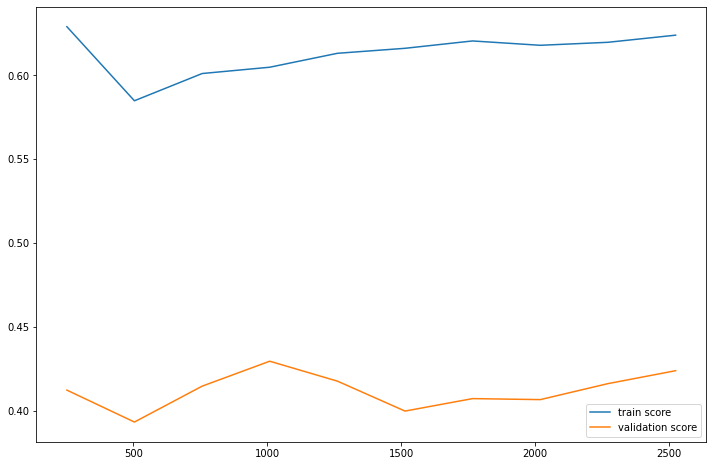

In [ ]:
courbe_apprentissage(model_5) # model_1, model_4, model_5, model_6, model_7 sont les modèles pour lesquels on a le moins d'overfitting

**Optimisation** des hyper-paramètres

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
#model_4
#model_1
# model_2
#model_ensemble
model_3

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [ ]:
# hyper_params = {'AdaBoostClassifier__adaboostclassifier__n_estimators': range(10,60,10),
#                 'AdaBoostClassifier__adaboostclassifier__learning_rate': np.linspace(0.1,0.5,6),
#                 'SVC__svc__gamma':[1e-3,1e-4],
#                 'SVC__svc__C': [1,10,100]}

# hyper_params = {'svc__gamma':[1e-3,1e-4],
#                 'svc__C': [1,10,100]}

# hyper_params = {'criterion':['gini','entropy'],
#                 'max_depth': np.arange(3, 15)}

hyper_params = {'n_estimators': [600,700,800],
                'max_features': ['log2'],
                'max_depth' : [6,7,8],
                'criterion' :['entropy']}
# {'criterion': 'entropy', 'max_depth': 7, 'max_features': 'log2', 'n_estimators': 600}

grid = GridSearchCV(model_3, hyper_params, cv=4, scoring='precision_macro')

grid.fit(X_train,y_train)
print(grid.best_params_)
print(grid.best_score_)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was pa

{'criterion': 'entropy', 'max_depth': 7, 'max_features': 'log2', 'n_estimators': 600}
0.5883557562978898


In [ ]:
# model_1 : {'learning_rate': 0.2, 'n_estimators': 30} ou {'learning_rate': 0.1, 'n_estimators': 10}
# model_4 : {'svc__C': 10, 'svc__gamma': 0.001}
# model_2 : {'criterion': 'entropy', 'max_depth': 3}

grid.best_estimator_.fit(X_train,y_train)
pd.Series(grid.best_estimator_.predict(X_test)).value_counts()

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


2    300
0     80
dtype: int64

In [ ]:
print('AVANT OPTIMISATION')
bilan(model_4)
print('\nAPRES OPTIMISATION')
bilan(grid.best_estimator_)

AVANT OPTIMISATION


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Nombre de prédictions : 380
Nombre de bonne prédiction sur la victoire de l'équipe à DOMICILE : 164 (cote moyenne de 1.8730487804878049)
Nombre de bonne prédiction sur la victoire de l'équipe à l'EXTÉRIEUR  : 54 (cote moyenne de 1.5711111111111107)
Nombre de bonne prédictions : 218 (soit 57.36842105263158 %)

  Le score avec model.score est : 57.36842105263158 %

  Gain total des cotes gagnantes : 392.02 (auquel on enlève 380)
  Rentable ? 12.019999999999982

APRES OPTIMISATION


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Nombre de prédictions : 380
Nombre de bonne prédiction sur la victoire de l'équipe à DOMICILE : 165 (cote moyenne de 1.8914545454545457)
Nombre de bonne prédiction sur la victoire de l'équipe à l'EXTÉRIEUR  : 53 (cote moyenne de 1.5728301886792448)
Nombre de bonne prédictions : 218 (soit 57.36842105263158 %)

  Le score avec model.score est : 57.36842105263158 %

  Gain total des cotes gagnantes : 395.45 (auquel on enlève 380)
  Rentable ? 15.449999999999989


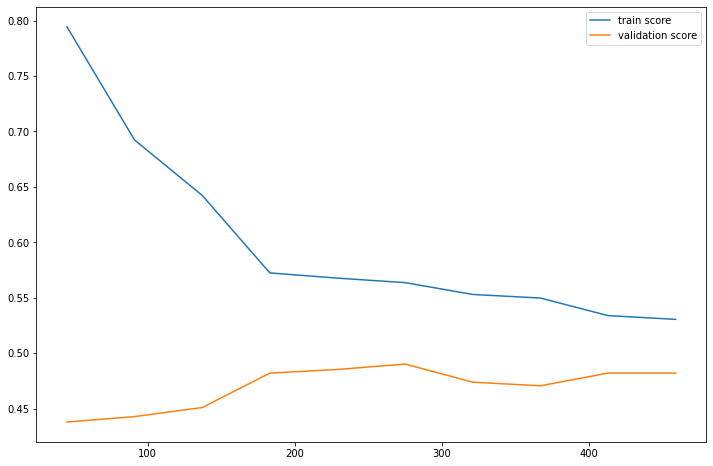

In [ ]:
courbe_apprentissage(grid.best_estimator_)

In [ ]:
X_train_full = X[X['Saison']!=annee_fin]
y_train_full = y[y['Saison']!=annee_fin]

X_test = X[X['Saison']==annee_fin]
y_test = y[y['Saison']==annee_fin]

y_train_full = y_train_full.drop('Saison',axis=1)
y_test = y_test.drop('Saison',axis=1)

X_train, X_validation = train_test_split(X_train_full, test_size=0.1, random_state=0)
y_train, y_validation = train_test_split(y_train_full, test_size=0.1, random_state=0)

print(X_train.shape, y_train.shape)
print(X_validation.shape, y_validation.shape)
print(X_test.shape, y_test.shape)

(3420, 100) (3420, 1)
(380, 100) (380, 1)
(288, 100) (288, 1)


In [ ]:
encode = StandardScaler()

X_train = pd.DataFrame(encode.fit_transform(X_train))
X_validation = pd.DataFrame(encode.transform(X_validation))
X_test = pd.DataFrame(encode.transform(X_test))

y_train.shape

(3420, 1)

In [ ]:
from tensorflow import keras

In [ ]:
model = keras.Sequential([
                          keras.layers.Dense(200, activation='relu', input_shape=X_train.shape[1:]),
                          keras.layers.Dense(100, activation='relu'),
                          keras.layers.Dense(3, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                               patience=10, 
                                               restore_best_weights=True)

history = model.fit(X_train,
                    y_train,
                    epochs=100,
                    validation_split=0.2,
                    callbacks=[early_stopping])

Epoch 1/100
95/95 [==============================] - 0s 3ms/step - loss: 3185.2915 - accuracy: 0.4556 - val_loss: 1.0640 - val_accuracy: 0.4658
Epoch 2/100
95/95 [==============================] - 0s 2ms/step - loss: 1.0693 - accuracy: 0.4618 - val_loss: 1.0582 - val_accuracy: 0.4658
Epoch 3/100
95/95 [==============================] - 0s 2ms/step - loss: 1.0658 - accuracy: 0.4618 - val_loss: 1.0565 - val_accuracy: 0.4658
Epoch 4/100
95/95 [==============================] - 0s 2ms/step - loss: 1.0641 - accuracy: 0.4618 - val_loss: 1.0554 - val_accuracy: 0.4658
Epoch 5/100
95/95 [==============================] - 0s 2ms/step - loss: 1.0634 - accuracy: 0.4618 - val_loss: 1.0555 - val_accuracy: 0.4658
Epoch 6/100
95/95 [==============================] - 0s 2ms/step - loss: 1.0629 - accuracy: 0.4618 - val_loss: 1.0567 - val_accuracy: 0.4658
Epoch 7/100
95/95 [==============================] - 0s 2ms/step - loss: 1.0628 - accuracy: 0.4618 - val_loss: 1.0567 - val_accuracy: 0.4658
Epoch 8/10

(0.0, 1.0)

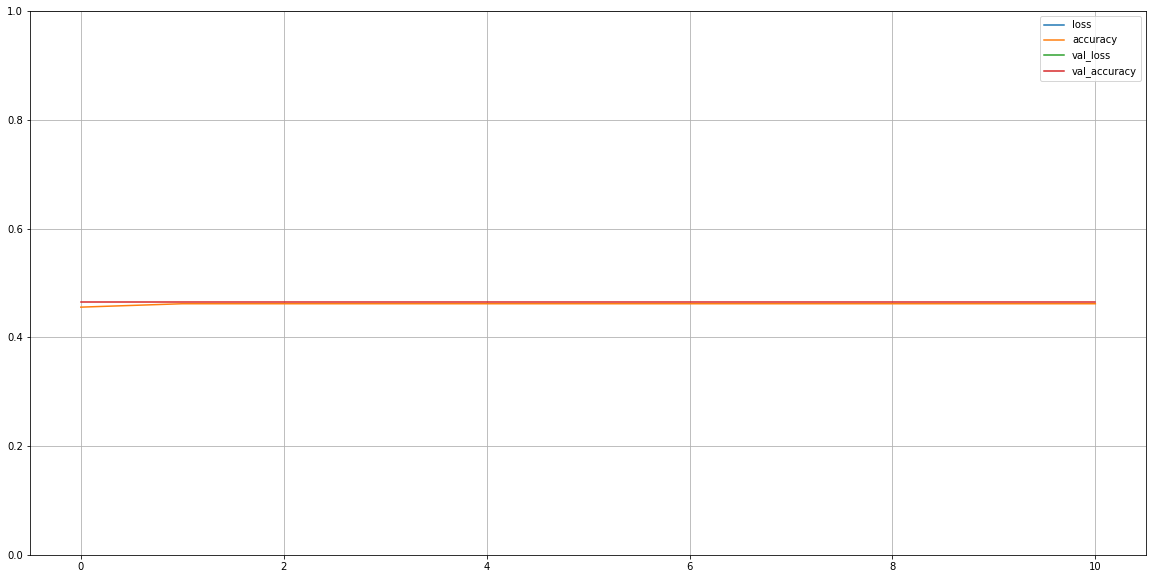

In [ ]:
pd.DataFrame(history.history).plot(figsize=(20,10))
plt.grid(True)
plt.gca().set_ylim(0,1)

In [ ]:
def bilan(model):
  prediction = pd.Series(model.predict_classes(X_test))

  cpt_total, cpt_home, cpt_draw, cpt_away, bonne_reponse,somme_cote_domicile,somme_cote_nul, somme_cote_away = 0,0,0,0,0,0,0,0

  '''
  H -> 2
  D -> 1
  A -> 0
  '''

  for pred, elt_test, B365H, B365D, B365A in zip(prediction,y_test.iterrows(),X_test.iloc[:,1], X_test.iloc[:,2], X_test.iloc[:,3]):
    cpt_total += 1
    if cpt_total < 11:
      indice = 11
    elif cpt_total < 101:
      indice = 12
    else :
      indice = 13
    if (pred == 2) and (str(elt_test)[indice] == '2'):
      bonne_reponse += 1
      cpt_home += 1
      somme_cote_domicile += B365H
    elif (pred == 1) and (str(elt_test)[indice] == '1'):
      bonne_reponse += 1
      cpt_draw += 1
      somme_cote_nul += B365D
    elif (pred == 0) and (str(elt_test)[indice] == '0'):
      bonne_reponse += 1
      cpt_away += 1
      somme_cote_away += B365A

  print(f'Nombre de prédictions : {cpt_total}')
  if cpt_home != 0:
    print(f'Nombre de bonne prédiction sur la victoire de l\'équipe à DOMICILE : {cpt_home} (cote moyenne de {somme_cote_domicile/cpt_home})')
  if cpt_draw != 0:
    print(f'Nombre de bonne prédiction sur un match NUL : {cpt_draw} (cote moyenne de  {somme_cote_nul/cpt_draw})')
  if cpt_away != 0:
    print(f'Nombre de bonne prédiction sur la victoire de l\'équipe à l\'EXTÉRIEUR  : {cpt_away} (cote moyenne de {somme_cote_away/cpt_away})')

  y_pred = prediction
  precision = precision_score(y_test, y_pred, average='macro')
  print(f'Nombre de bonne prédictions : {bonne_reponse} (soit {(bonne_reponse/cpt_total)*100} %)\n\n\
  Le score de précision du model est : {precision} %\n\n\
  Gain total des cotes gagnantes : {somme_cote_domicile+somme_cote_nul+somme_cote_away} (auquel on enlève {cpt_total})\n\
  Rentable ? {somme_cote_domicile+somme_cote_nul+somme_cote_away - cpt_total}')

In [ ]:
bilan(model)

Nombre de prédictions : 288
Nombre de bonne prédiction sur la victoire de l'équipe à DOMICILE : 129 (cote moyenne de 2.2428682170542644)
Nombre de bonne prédictions : 129 (soit 44.79166666666667 %)

  Le score de précision du model est : 0.14930555555555555 %

  Gain total des cotes gagnantes : 289.3300000000001 (auquel on enlève 288)
  Rentable ? 1.3300000000000978


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
